# **Aprendizaje por Refuerzo: SARSA**

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

In [2]:
# Laberinto 1D de 5 posiciones:
# S0 (izquierda del todo), S1, S2, S3, S4 (derecha del todo)

In [3]:
N_STATES = 5
ACTIONS  = ['left', 'right']

### **Modelización del entorno**

In [4]:
class Env:
  def __init__(self, n_states): # método "init". Se llama automáticamente al definir una instancia
    self.nstates = n_states # self.nstates es una variable interna de la instancia creada de Env
    self.reset()
  def reset(self): # resetea el juego
    self.S = 0 # habitación del laberinto en el que está el agente (0 .. n_states-1)
    self.step_counter = 0 # cuántos pasos se han ejecutado desde el comienzo del juego
  def display(self):
    env_list = ["-"]*self.nstates + ["T"]
    if self.S != "terminal":
      env_list[self.S] = "o"
    print("Total steps: {}".format(self.step_counter))
    print("".join(env_list))
  def step(self, action):
    reward = 0
    fin = False
    self.step_counter += 1
    if action == "left":
      if self.S == 0: # estamos a la izquierda del todo
        #self.S = self.nstates-1 # efecto "agujero de gusano"
        pass # no hago nada
      else:
        self.S = self.S - 1
    else: # action es "right"
      if self.S == (self.nstates-1): # estábamos en la última casilla
        self.S = "terminal"
        reward = 1
        fin = True
      else:
        self.S = self.S + 1

    S_nuevo = self.S
    return S_nuevo, reward, fin

In [5]:
entorno = Env(N_STATES) # definir una instancia de la clase Env

###Agente SARSA

In [6]:
class Agent:
  def __init__(self,
               gamma, # factor de descuento
               alpha, # velocidad de aprendizaje
               epsilon, # tasa de exploración (0: nunca explora, 1: explora siempre)
               nstates # número de estados del entorno
               ):
    self.gamma = gamma
    self.alpha = alpha
    self.nstates = nstates
    self.epsilon = epsilon
    self.reset()

  def reset(self):
    self.Q_table = pd.DataFrame(np.zeros((self.nstates, len(ACTIONS))), columns=ACTIONS)

  def choose_action(self, state):
    if (state=="terminal") or np.random.random() < self.epsilon: # se explora
      return np.random.choice(ACTIONS)

    # no toca explorar
    valoraciones_acciones = self.Q_table.iloc[state]
    if (valoraciones_acciones==0).all():
      return np.random.choice(ACTIONS)

    return valoraciones_acciones.idxmax() # nombre de la columna que tiene valoración mayor


  def update_table(self, state, action, reward, new_state, new_action):
    q_celda_antes_cambio = self.Q_table.loc[state,action] # Q(s,a) en transparencias
    if new_state != "terminal":
      delta_q = self.alpha * (reward + self.gamma*self.Q_table.loc[new_state, new_action] - q_celda_antes_cambio) # Delta Q en transparencias
    else:
      delta_q = self.alpha * (reward - q_celda_antes_cambio)

    self.Q_table.loc[state,action] += delta_q

In [7]:
agente = Agent(gamma=0.9, alpha=0.1, epsilon=1, nstates=entorno.nstates)

In [8]:
agente.Q_table

left  right
0   0.0    0.0
1   0.0    0.0
2   0.0    0.0
3   0.0    0.0
4   0.0    0.0

In [9]:
from tqdm import tqdm

nepisodios = 500
agente = Agent(gamma=0.9, alpha=0.1, epsilon=0.1, nstates=entorno.nstates)
agente.reset()
print("Tabla inicial:")
display(agente.Q_table)
duraciones_episodios = []

for episodio in tqdm(range(nepisodios)):
  entorno.reset()
  fin = False
  S = entorno.S
  accion = agente.choose_action(S)
  # un episodio completo:
  while not fin: # mientras no termine el episodio ...
    S_nuevo, reward, fin = entorno.step(accion)
    accion_nueva = agente.choose_action(S_nuevo)

    agente.update_table(S, accion, reward, S_nuevo, accion_nueva)

    S = S_nuevo
    accion = accion_nueva

  duraciones_episodios.append(entorno.step_counter)

print("Tabla final:")
display(agente.Q_table)

Tabla inicial:


left  right
0   0.0    0.0
1   0.0    0.0
2   0.0    0.0
3   0.0    0.0
4   0.0    0.0

100%|██████████| 500/500 [00:01<00:00, 317.79it/s]

Tabla final:


left     right
0  0.498025  0.589509
1  0.442735  0.686492
2  0.546863  0.745346
3  0.619503  0.889853
4  0.752332  1.000000

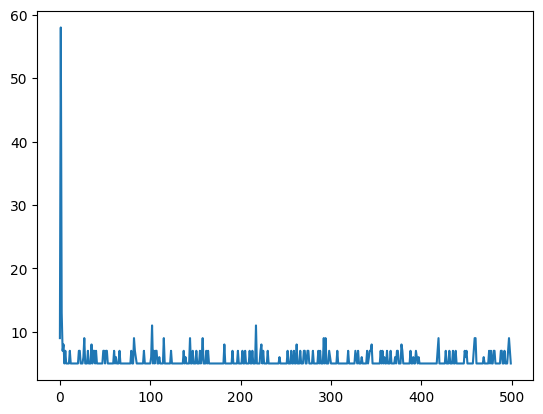

In [10]:
plt.plot(duraciones_episodios);

In [11]:
# número total de steps ejecutados:
sum(duraciones_episodios)

2825